# Plant Disease Classification using ResNet-9

Este notebook treina um modelo ResNet-9 para classificação de doenças em plantas no Google Colab.

**Pré-requisitos:**
- Dataset deve estar no Google Drive em: `My Drive/DeepLearning/data/New Plant Diseases Dataset`
- Se não tiver o dataset, baixe de: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

**Características:**
- Arquitetura ResNet-9 para treinamento eficiente
- One Cycle Learning Rate policy
- Gradient clipping para prevenir explosão de gradientes
- Inicialização He para estabilidade numérica
- Normalização ImageNet
- Aceleração GPU (CUDA)

## 1. Setup e Instalação

In [3]:
# Instalar pacotes necessários
!pip install torchsummary -q

In [4]:
# Importar bibliotecas
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 2. Montar Google Drive

In [5]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verificar caminho do dataset
DATA_DIR = "/content/drive/My Drive/DeepLearning/data/New Plant Diseases Dataset"
if os.path.exists(DATA_DIR):
    print(f"✓ Dataset encontrado em: {DATA_DIR}")
    print(f"  - Pasta train existe: {os.path.exists(os.path.join(DATA_DIR, 'train'))}")
    print(f"  - Pasta valid existe: {os.path.exists(os.path.join(DATA_DIR, 'valid'))}")
else:
    print(f"✗ Dataset não encontrado em: {DATA_DIR}")
    print("  Por favor, faça upload do dataset para o Google Drive ou atualize o caminho DATA_DIR.")
    print("  Baixe o dataset de: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset")

Mounted at /content/drive
✓ Dataset encontrado em: /content/drive/My Drive/DeepLearning/data/New Plant Diseases Dataset
  - Pasta train existe: True
  - Pasta valid existe: True


## 3. Configuração

In [6]:
# Caminhos do dataset
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parâmetros de treinamento
RANDOM_SEED = 7
BATCH_SIZE = 32
EPOCHS = 10
MAX_LR = 0.0001  # Reduzido para prevenir explosão de gradientes
GRAD_CLIP = 1.0  # Gradient clipping para estabilidade
WEIGHT_DECAY = 1e-4  # Regularização L2
INPUT_SHAPE = (3, 256, 256)

# Caminhos para salvar modelo
OUTPUT_DIR = '/content/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)
MODEL_PATH = os.path.join(OUTPUT_DIR, 'plant-disease-model.pth')
MODEL_COMPLETE_PATH = os.path.join(OUTPUT_DIR, 'plant-disease-model-complete.pth')

print("Configuração:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Max Learning Rate: {MAX_LR}")
print(f"  Gradient Clipping: {GRAD_CLIP}")
print(f"  Weight Decay: {WEIGHT_DECAY}")

Configuração:
  Batch Size: 32
  Epochs: 10
  Max Learning Rate: 0.0001
  Gradient Clipping: 1.0
  Weight Decay: 0.0001


## 4. Configuração de Dispositivo

In [7]:
def get_default_device():
    """Seleciona GPU se disponível, senão CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) para o dispositivo escolhido"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrapper para dataloader que move dados para um dispositivo"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield batch de dados após mover para dispositivo"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Número de batches"""
        return len(self.dl)


# Definir dispositivo
device = get_default_device()
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## 5. Arquitetura do Modelo

In [8]:
def accuracy(outputs, labels):
    """Calcular acurácia"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    """Classe base para modelos de classificação de imagem"""

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Gerar previsões
        loss = F.cross_entropy(out, labels) # Calcular loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Gerar previsão
        loss = F.cross_entropy(out, labels)  # Calcular loss
        acc = accuracy(out, labels)          # Calcular acurácia
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combinar loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


def ConvBlock(in_channels, out_channels, pool=False):
    """Bloco de convolução com BatchNormalization"""
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    """Arquitetura ResNet-9 para classificação de imagens"""

    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)  # out_dim: 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True)  # out_dim: 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True)  # out_dim: 512 x 4 x 4
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

        # Inicialização He para estabilidade numérica
        self._initialize_weights()

    def _initialize_weights(self):
        """Inicializar pesos usando inicialização He para melhor fluxo de gradiente"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, xb):
        """Forward pass"""
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


print("✓ Arquitetura do modelo definida")

✓ Arquitetura do modelo definida


## 6. Funções de Treinamento

In [9]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Avaliar modelo no conjunto de validação"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    """Obter learning rate atual"""
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    """Treinar modelo usando política de learning rate One Cycle"""
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Scheduler para one cycle learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                 steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_losses = []
        lrs = []
        skipped_batches = 0

        for batch in train_loader:
            loss = model.training_step(batch)

            # Verificar valores inválidos (NaN ou Inf)
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️  Aviso: Loss inválido detectado ({loss.item()}), pulando batch")
                skipped_batches += 1
                continue

            train_losses.append(loss)
            loss.backward()

            # Gradient clipping usando norma (mais efetivo que valor)
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Registrar e atualizar learning rates
            lrs.append(get_lr(optimizer))
            sched.step()

        if skipped_batches > 0:
            print(f"   Pulados {skipped_batches} batches com loss inválido na época {epoch}")

        # Validação
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


print("✓ Funções de treinamento definidas")

✓ Funções de treinamento definidas


## 7. Funções de Visualização

In [10]:
def denormalize(tensor):
    """Desnormaliza tensor para visualização"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean


def show_image(image, label, classes):
    """Display a single image with its label"""
    print("Label: " + classes[label] + " (" + str(label) + ")")
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def show_batch(data):
    """Show a batch of training instances"""
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        # Desnormaliza as imagens antes de mostrar
        denorm_images = torch.stack([denormalize(img) for img in images[:32]])
        ax.imshow(make_grid(denorm_images, nrow=8).permute(1, 2, 0))
        plt.show()
        break


def plot_accuracies(history):
    """Plot accuracy vs epochs"""
    accuracies = [x['val_accuracy'].cpu() if isinstance(x['val_accuracy'], torch.Tensor) else x['val_accuracy'] for x in history]
    plt.figure(figsize=(10, 6))
    plt.plot(accuracies, '-x')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title('Acurácia vs. Número de Épocas')
    plt.grid(True)
    plt.show()


def plot_losses(history):
    """Plot training and validation losses"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu() if isinstance(x['val_loss'], torch.Tensor) else x['val_loss'] for x in history]
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, '-bx', label='Treinamento')
    plt.plot(val_losses, '-rx', label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Número de Épocas')
    plt.grid(True)
    plt.show()


def plot_lrs(history):
    """Plot learning rate schedule"""
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.figure(figsize=(10, 6))
    plt.plot(lrs)
    plt.xlabel('Número do Batch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Número do Batch')
    plt.grid(True)
    plt.show()


print("✓ Funções de visualização definidas")

✓ Funções de visualização definidas


## 8. Carregar Dataset

In [29]:
# Definir seed aleatória para reprodutibilidade
torch.manual_seed(RANDOM_SEED)

# Transformações com normalização ImageNet para estabilidade
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Adicionado para redimensionar imagens
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Adicionado para redimensionar imagens
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Carregar datasets
print("Carregando datasets...")
train_dataset = ImageFolder(TRAIN_DIR, transform=train_transform)
valid_dataset = ImageFolder(VALID_DIR, transform=valid_transform)

# Obter estatísticas do dataset
diseases = os.listdir(TRAIN_DIR)
print(f"Total de classes de doenças: {len(diseases)}")

plants = []
num_diseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        num_diseases += 1

print(f"Número de plantas únicas: {len(plants)}")
print(f"Número de doenças: {num_diseases}")

# Contar imagens por classe
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(os.path.join(TRAIN_DIR, disease)))

n_train = sum(nums.values())
print(f"Total de imagens de treinamento: {n_train}")
print(f"Total de imagens de validação: {len(valid_dataset)}")

# Mostrar distribuição de classes
print("\nExemplo de classes:")
for i, cls in enumerate(train_dataset.classes[:5]):
    print(f"  {i}: {cls}")
print(f"  ... ({len(train_dataset.classes)} classes totais)")

Carregando datasets...
Total de classes de doenças: 38
Número de plantas únicas: 14
Número de doenças: 26
Total de imagens de treinamento: 70338
Total de imagens de validação: 17572

Exemplo de classes:
  0: Apple___Apple_scab
  1: Apple___Black_rot
  2: Apple___Cedar_apple_rust
  3: Apple___healthy
  4: Blueberry___healthy
  ... (38 classes totais)


## 9. Criar Data Loaders

In [12]:
print("Criando data loaders...")

# Usar pin_memory com CUDA para transferência de dados mais rápida
use_pin_memory = device.type == 'cuda'

train_dl = DataLoader(train_dataset, BATCH_SIZE, shuffle=True,
                     num_workers=2, pin_memory=use_pin_memory)
valid_dl = DataLoader(valid_dataset, BATCH_SIZE,
                     num_workers=2, pin_memory=use_pin_memory)

# Mover para dispositivo
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

print(f"Batches de treino: {len(train_dl)}")
print(f"Batches de validação: {len(valid_dl)}")
print("✓ Data loaders criados")

Criando data loaders...
Batches de treino: 2199
Batches de validação: 550
✓ Data loaders criados


## 10. Visualizar Batch de Exemplo (Opcional)

In [13]:
# Descomente para visualizar um batch de imagens de treinamento
# show_batch(train_dl)

## 11. Criar Modelo

In [14]:
print("Criando modelo...")

model = to_device(ResNet9(3, len(train_dataset.classes)), device)
print(model)

# Imprimir resumo do modelo
if torch.cuda.is_available():
    print("\nResumo do Modelo:")
    summary(model, INPUT_SHAPE)

print("\n✓ Modelo criado e movido para dispositivo")

Criando modelo...
ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

## 12. Treinar Modelo

In [16]:
print("=" * 80)
print(f"Iniciando treinamento para {EPOCHS} épocas...")
print("=" * 80)

history = fit_OneCycle(
    EPOCHS,
    MAX_LR,
    model,
    train_dl,
    valid_dl,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    opt_func=torch.optim.Adam
)

print("=" * 80)
print("Treinamento concluído!")
print("=" * 80)

Iniciando treinamento para 10 épocas...
Epoch [0], last_lr: 0.00003, train_loss: 1.1833, val_loss: 0.6086, val_acc: 0.8709
Epoch [1], last_lr: 0.00008, train_loss: 0.3218, val_loss: 0.2040, val_acc: 0.9419
Epoch [2], last_lr: 0.00010, train_loss: 0.1235, val_loss: 0.1185, val_acc: 0.9611
Epoch [3], last_lr: 0.00010, train_loss: 0.0650, val_loss: 0.0656, val_acc: 0.9781
Epoch [4], last_lr: 0.00008, train_loss: 0.0349, val_loss: 0.0546, val_acc: 0.9825
Epoch [5], last_lr: 0.00006, train_loss: 0.0198, val_loss: 0.0271, val_acc: 0.9921
Epoch [6], last_lr: 0.00004, train_loss: 0.0087, val_loss: 0.0148, val_acc: 0.9958
Epoch [7], last_lr: 0.00002, train_loss: 0.0036, val_loss: 0.0101, val_acc: 0.9970
Epoch [8], last_lr: 0.00000, train_loss: 0.0011, val_loss: 0.0087, val_acc: 0.9976
Epoch [9], last_lr: 0.00000, train_loss: 0.0005, val_loss: 0.0074, val_acc: 0.9980
Treinamento concluído!


## 13. Visualizar Resultados

Pulando - Gerando gráficos de treinamento...



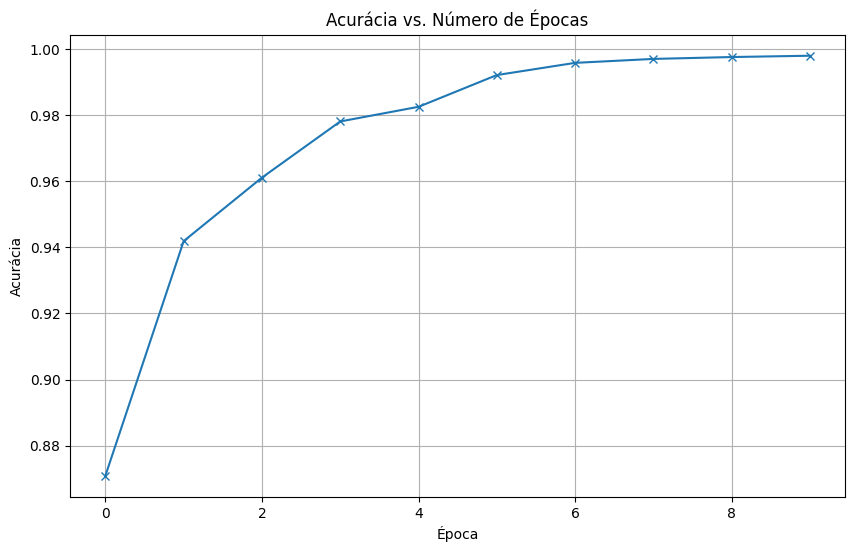

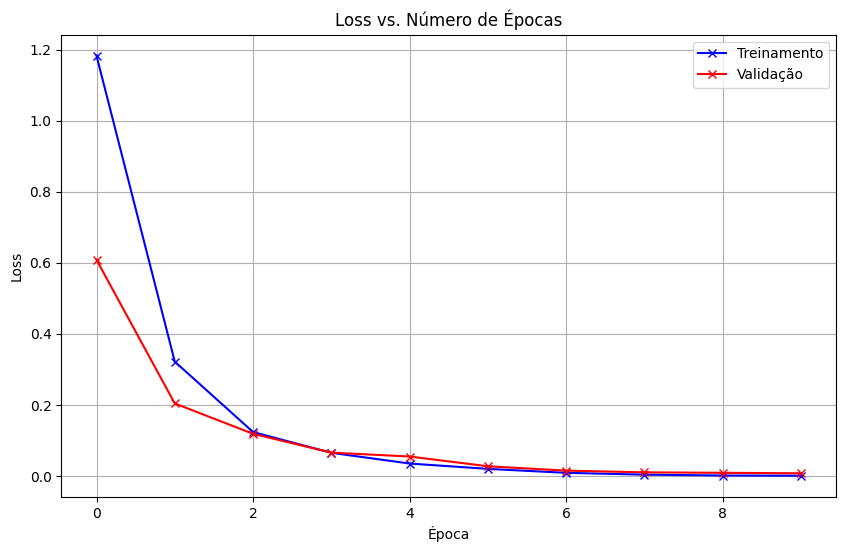

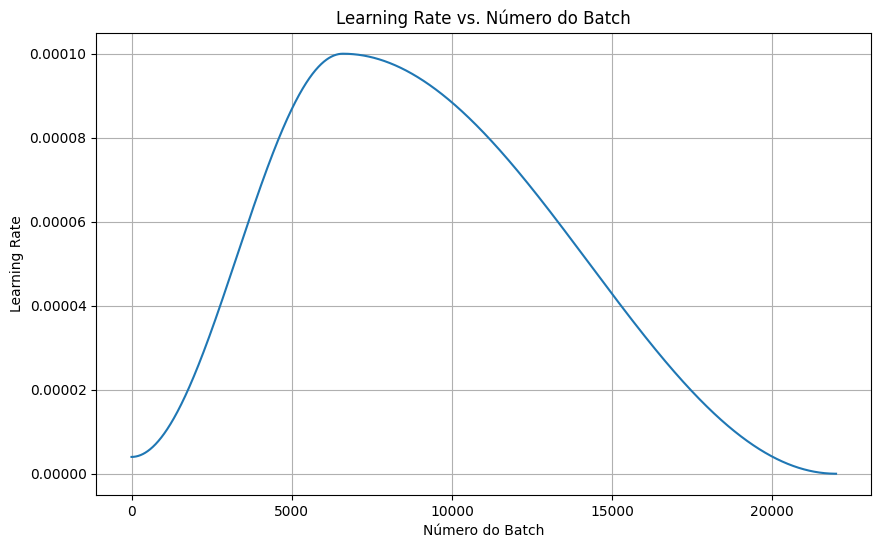

In [17]:
print("Pulando - Gerando gráficos de treinamento...\n")

# Plotar acurácia
plot_accuracies(history)

# Plotar losses
plot_losses(history)

# Plotar learning rates
plot_lrs(history)

## 14. Salvar Modelo

In [18]:
print("Salvando modelo...\n")

# Salvar state dict do modelo
torch.save(model.state_dict(), MODEL_PATH)
print(f"✓ State dict do modelo salvo em: {MODEL_PATH}")

# Salvar modelo completo
torch.save(model, MODEL_COMPLETE_PATH)
print(f"✓ Modelo completo salvo em: {MODEL_COMPLETE_PATH}")

# Opcional: Salvar no Google Drive
drive_output_dir = "/content/drive/My Drive/DeepLearning/models"
os.makedirs(drive_output_dir, exist_ok=True)

drive_model_path = os.path.join(drive_output_dir, 'plant-disease-model.pth')
drive_model_complete_path = os.path.join(drive_output_dir, 'plant-disease-model-complete.pth')

torch.save(model.state_dict(), drive_model_path)
torch.save(model, drive_model_complete_path)
print(f"✓ Modelos também salvos no Google Drive: {drive_output_dir}")

print("\n" + "=" * 80)
print("Treinamento Finalizado com Sucesso!")
print("=" * 80)

Salvando modelo...

✓ State dict do modelo salvo em: /content/output/plant-disease-model.pth
✓ Modelo completo salvo em: /content/output/plant-disease-model-complete.pth
✓ Modelos também salvos no Google Drive: /content/drive/My Drive/DeepLearning/models

Treinamento Finalizado com Sucesso!


## 15. Função de Predição

In [30]:
def predict_image(img, model, classes, device):
    """Prever a classe de uma única imagem"""
    # Converter para batch de 1
    xb = to_device(img.unsqueeze(0), device)
    # Obter previsões do modelo
    yb = model(xb)
    # Selecionar índice com maior probabilidade
    _, preds = torch.max(yb, dim=1)
    # Recuperar label da classe
    return classes[preds[0].item()]


def test_prediction(image_path):
    """Testar predição em uma única imagem"""
    # Carregar e transformar imagem
    img = Image.open(image_path)
    img_tensor = valid_transform(img)

    # Fazer predição
    model.eval()
    with torch.no_grad():
        prediction = predict_image(img_tensor, model, train_dataset.classes, device)

    # Exibir resultado
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predição: {prediction}")
    plt.axis('off')
    plt.show()

    return prediction


print("✓ Funções de predição definidas")
print("\nPara testar uma imagem:")
print("  test_prediction('/content/drive/My Drive/DeepLearning/data/test_apple.jpeg')")

✓ Funções de predição definidas

Para testar uma imagem:
  test_prediction('/content/drive/My Drive/DeepLearning/data/test_apple.jpeg')


## 16. Testar Predição (Opcional)

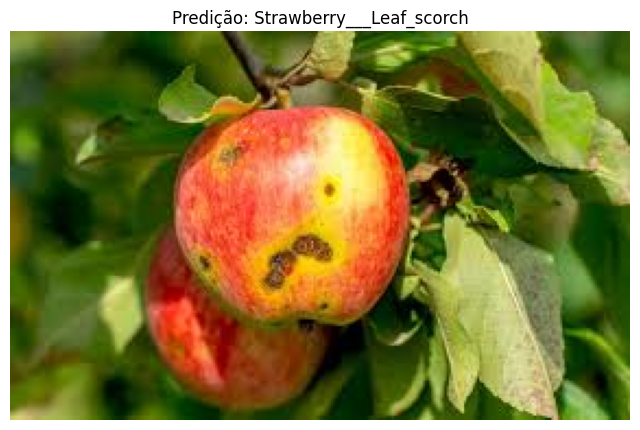

Resultado: Strawberry___Leaf_scorch


In [31]:
# Exemplo: Testar com uma imagem do dataset de validação
# Descomente e ajuste o caminho conforme necessário

from PIL import Image
test_image_path = "/content/drive/My Drive/DeepLearning/data/test_apple.jpeg"
if os.path.exists(test_image_path):
    prediction = test_prediction(test_image_path)
    print(f"Resultado: {prediction}")
else:
     print("Imagem não encontrada. Ajuste o caminho.")

## 17. Baixar Arquivos do Modelo (Opcional)

In [34]:
# Descomente para baixar arquivos do modelo para sua máquina local
from google.colab import files
files.download(MODEL_PATH)
files.download(MODEL_COMPLETE_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Resumo do Treinamento

Este notebook implementa um modelo ResNet-9 para classificação de doenças em plantas com as seguintes características:

### Arquitetura do Modelo:
- ResNet-9 com conexões residuais
- Batch normalization para treinamento estável
- Inicialização He para melhor fluxo de gradiente

### Técnicas de Treinamento:
- Política de Learning Rate One Cycle para convergência mais rápida
- Gradient clipping para prevenir explosão de gradientes
- Regularização L2 (weight decay)
- Normalização ImageNet
- Detecção de loss inválido (NaN/Inf)

### Dataset:
- Localização: Google Drive em `My Drive/DeepLearning/data/New Plant Diseases Dataset`
- Múltiplas espécies de plantas e doenças
- Divisões de treinamento e validação

### Hiperparâmetros Utilizados:
- **Batch Size:** 32
- **Epochs:** 10
- **Max Learning Rate:** 0.0001
- **Gradient Clipping:** 1.0
- **Weight Decay:** 1e-4
- **Optimizer:** Adam
- **Scheduler:** OneCycleLR


### Referências:
- Dataset: [New Plant Diseases Dataset - Kaggle](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset)
- Paper: "Deep Residual Learning for Image Recognition" (He et al., 2015)
- One Cycle Policy: "Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates" (Smith, 2018)